# MAGIC AI Workshop 03 Introduction to natural language processing

In this lab, we will introduce tools for natural language processing (NLP), from basic data preparation through to some exploration and building a simple machine learning model. We are only scratching the surface of what is possible with NLP methods in this lab. See the NLTK website for further examples. 

You'll need several packages for the lab including:

- `nltk`: the Python natural language toolkit
- `gensim`: a library for topic modeling
- `wordcloud`: builds and displays word clouds
- `UMAP`: performs dimension reduction for visualization of high-dimension data

Use `pip` or `conda` to install these before starting. You also need the file `text_utils.py` that has some helper functions for working with twitter data. 

Start by loading packages for basic data manipulation

In [4]:
import numpy as np
import re
import pandas as pd
import text_utils

Natural language processing depends on a large number of pre-made lexicons and look-up tables (we'll be using these below). You can install just the ones you need, or download all in one go as follows:

In [5]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

## or

# nltk.download('all')

[nltk_data] Downloading package punkt to /Users/u0784726/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/u0784726/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/u0784726/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Data

We'll use a set of tweets related to climate change from 2015 to 2018, taken from:

https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset

The data are held in the file *twitter_sentiment_data.csv*, which you can download from the Google drive folder. 

https://drive.google.com/drive/folders/1GMEY1fYEj1YMI__u3hU4y6agnrz3ekna?usp=drive_link

Read these in and take a quick look. There are three columns: a sentiment estimate, the tweet (`message`) and a tweet id. The sentiment estimate was provided by a group of experts and are tagged as follows:

- `2` (News): the tweet links to factual news about climate change
- `1` (Pro): the tweet supports the belief of man-made climate change
- `0` (Neutral): the tweet neither supports nor refutes the belief of man-made climate change
- `-1`(Anti): the tweet does not believe in man-made climate change

In [6]:
dat = pd.read_csv("./datafiles/twitter_sentiment_data.csv")
dat.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Our basic plan here is:

1. Prepare the data for analysis. 
2. Visualize and explore the data
3. Create an embedding for the tweets. This represents each tweet as a vector of numbers, and can be used for further analysis
4. Create a simple machine learning model to predict the sentiment of a tweet

## Text processing

Processing text data into a usable form can be one of the most time consuming parts of the analysis. Basically, we want to remove any characters or words that are irrelevant to any analysis. In addition, we should try to simplify and standardize the language used. For example, a computer will not necessarily recognize that 'see' and 'seen' are related to each other. 


### General cleaning

First, we'll remove any retweets from the dataset (indicated by `RT` at the start of the message). While there are some applications where the number of retweets are of interest, we will consider them as duplicates for this exercise. 

In [7]:
dat = dat[~dat["message"].str.startswith('RT')]
dat = dat.reset_index()

To illustrate the next steps, we'll extract the fourth tweet from the dataset:

In [8]:
tweet = dat.message[3]
print(tweet)

#BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change... https://t.co/HCIZrPUhLF


This is a typical tweet and has several issues for text processing:

- There is a URL at the end of the tweet
- There is at least one username (`@...`)
- There are several hashtag (`#...`)

We can carry out some initial cleaning using Python's regular expression library:

In [9]:
import re

In [10]:
## Remove URLS
tweet = re.sub(r"https?://\S+", "", tweet)
print(tweet)

#BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change... 


In [11]:
## Remove usernames
tweet = re.sub(r'@\w+', '', tweet)
print(tweet)

#BeforeTheFlood Watch #BeforeTheFlood right here, as  travels the world to tackle climate change... 


Next we need to expand hashtags. This uses the function from the `text_utils.py` file, so make sure this is present and imported. Note that this not only removes the `#` but also expands out multiword hashtags

In [12]:
tweet = text_utils.expand_hashtags(tweet)
print(tweet)

Before The Flood Watch Before The Flood right here, as  travels the world to tackle climate change... 


Next, we remove punctuation and extra spaces, and convert everything to lower case

In [13]:
tweet = re.sub("[^a-zA-Z]+", " ", tweet)
tweet = re.sub(r"\s+", " ", tweet)
tweet = tweet.lower()
print(tweet)

before the flood watch before the flood right here as travels the world to tackle climate change 


We'll now remove stopwords, a predefined set of commonly occurring words that have little value in analysis (e.g. the, and, ...). There are stopwords available in over 20 languages - we'll use the English words here. To change this, change the language imported in the `text_utils.py` file.

In [14]:
tweet = text_utils.remove_stopwords(tweet).lower() 
print(tweet)

flood watch flood right travels world tackle climate change


### Word matching

The last thing we'll need to do is match words with similar meanings. There's a couple of approaches to this: stemming and lemmatization. Stemming strips words back to the core stem using `PorterStemmer()`. For example, here are 5 different words related to programming. The stemmer converts them all to `program`:

In [15]:
from nltk.stem import PorterStemmer
# Initialize Python porter stemmer
ps = PorterStemmer()
# Example inflections to reduce
example_words = ["program","programming","programer","programs","programmed"]
for word in example_words:
    print(f"{word}: {ps.stem(word)}")

program: program
programming: program
programer: program
programs: program
programmed: program


One disadvantage to this is that the stems may no longer reflect actual words. For example, the stem to climate is `climat`:

In [16]:
ps.stem("climate")

'climat'

The second issue is that stemming does not account for context - that words with different meanings may be spelled the same, and can only be distinguished in the context of the sentence. 

Lemmatization attempts to avoid these issues by converting words to a standard form, and accounting for the meaning of the surrounding words. For example, compare the conversion of `saw` in these two phrases:

In [17]:
text_utils.lemmatize("Owen saw a rabbit") 

'Owen see a rabbit'

With:

In [18]:
text_utils.lemmatize("Owen cut a plank with a saw") 

'Owen cut a plank with a saw'

If we do this now with our tweet, you'll see that it shortens `travels` to `travel`. 

In [19]:
tweet = text_utils.lemmatize(tweet) 
print(tweet)

flood watch flood right travel world tackle climate change


The text_utils.py file contains a function that puts all of these together (`text_clean`]: 

In [20]:
text_utils.text_clean(dat.message[3])

'flood watch flood right travel world tackle climate change'

We can `map` this function across all tweets in the dataset to create a new column containing the processed data called `text_clean`. One final thing: we'll remove any tweets that are 32 characters or less, as these may have little usable text. This may take a minute or so to run.

In [21]:
dat['text_clean'] = dat['message'].map(text_utils.text_clean)
dat['text_len'] = dat['text_clean'].map(text_utils.text_len)
dat = dat[dat['text_len'] > 32]

display(dat)

,index,sentiment,message,tweetid,text_clean,text_len
0,0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,climate change interesting hustle global warmi...,78
1,2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,fabulous leonardo di caprio film climate chang...,67
2,5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489,unamshow awache kujinga na iko global warming,45
3,9,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028,flood watch flood right travel world tackle cl...,58
4,11,1,"Bangladesh did not cause climate change, so th...",793129746003615745,bangladesh cause climate change country need a...,74
...,...,...,...,...,...,...
18861,43934,1,#Awareness Walls aren$q$t answer to people fle...,791278043235049472,awareness walls q answer people flee war clima...,89
18862,43936,1,#AikBaatSuniThi \nGlobal warming has negative ...,791293803877502976,aik baat suni thi global warm negative effect ...,58
18863,43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464,dear yeah right human mediated climate change ...,66
18864,43939,1,What will your respective parties do to preven...,791316857403936768,respective party prevent climate change globally,48


### Tokenization

For some of the analysis we will do below, we'll need to convert the text strings to individual words or tokens. As an example, here is the single, cleaned tweet broken down into individual words.

In [22]:
from nltk import word_tokenize
tokens = word_tokenize(tweet)
for token in tokens:
    print(token)

flood
watch
flood
right
travel
world
tackle
climate
change


## Exploration

We can now use the cleaned text data to do some exploration. We'll start by making some word clouds. These are a very common visualization of text data, where words are randomly placed on a figure and scaled according to their frequency. We'll use the `wordcloud` package to make plots, and define a function for plotting so we can try different subsets of the data. 

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt  

def draw_cloud(column: pd.Series, stopwords=None):
    all_words = ' '.join([text for text in column]) 
    wordcloud = WordCloud(width=1200, height=800, random_state=42, 
                          background_color='white', colormap='bone',
                          stopwords=stopwords,
                          max_font_size=110, collocations=False).generate(all_words) 
    plt.figure(figsize=(16, 12)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis('off')
    plt.show()

First, let's plot all the data. This is, not surprisingly, dominated by the words 'climate' and 'change'

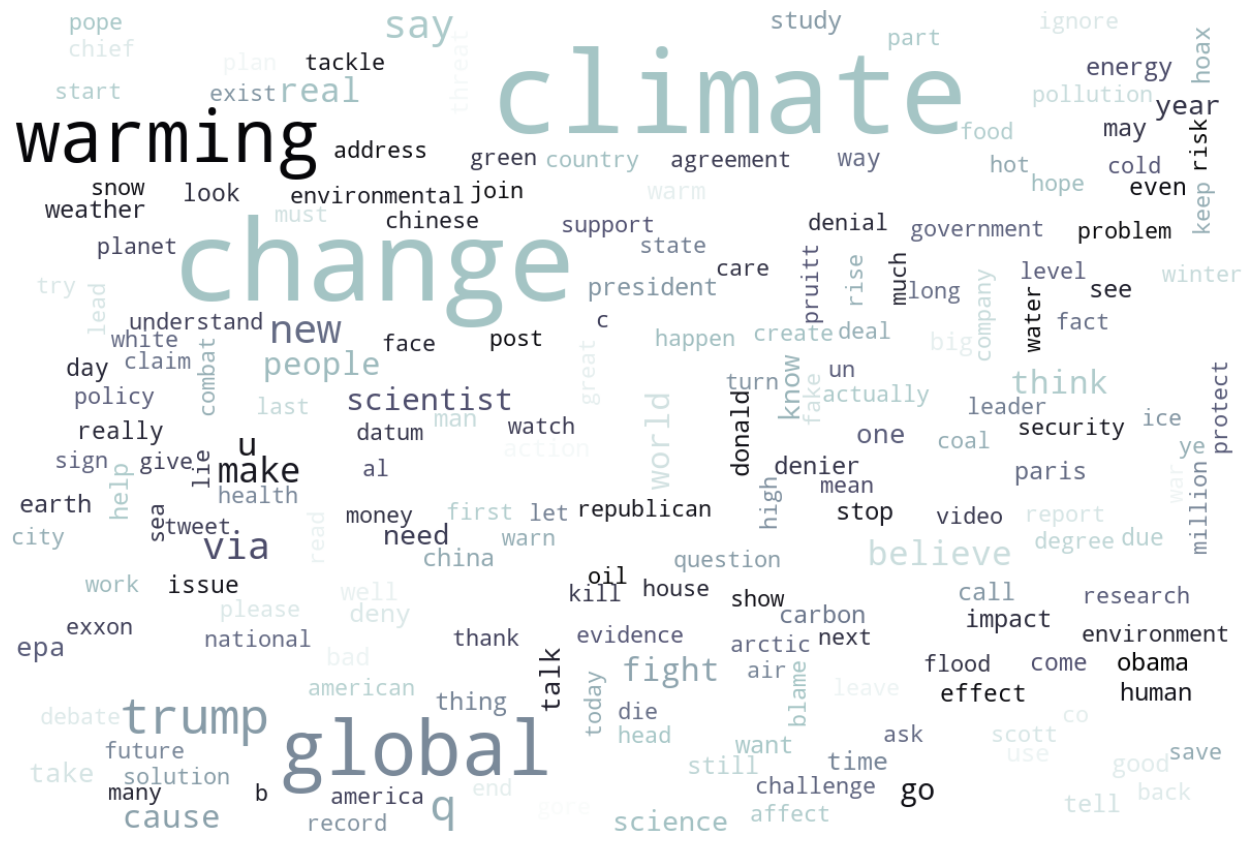

In [24]:
draw_cloud(dat['text_clean'])

For the next plot, we'll extract only the 'pro' tweets, and skip plotting climate and change by setting them as stopwords 

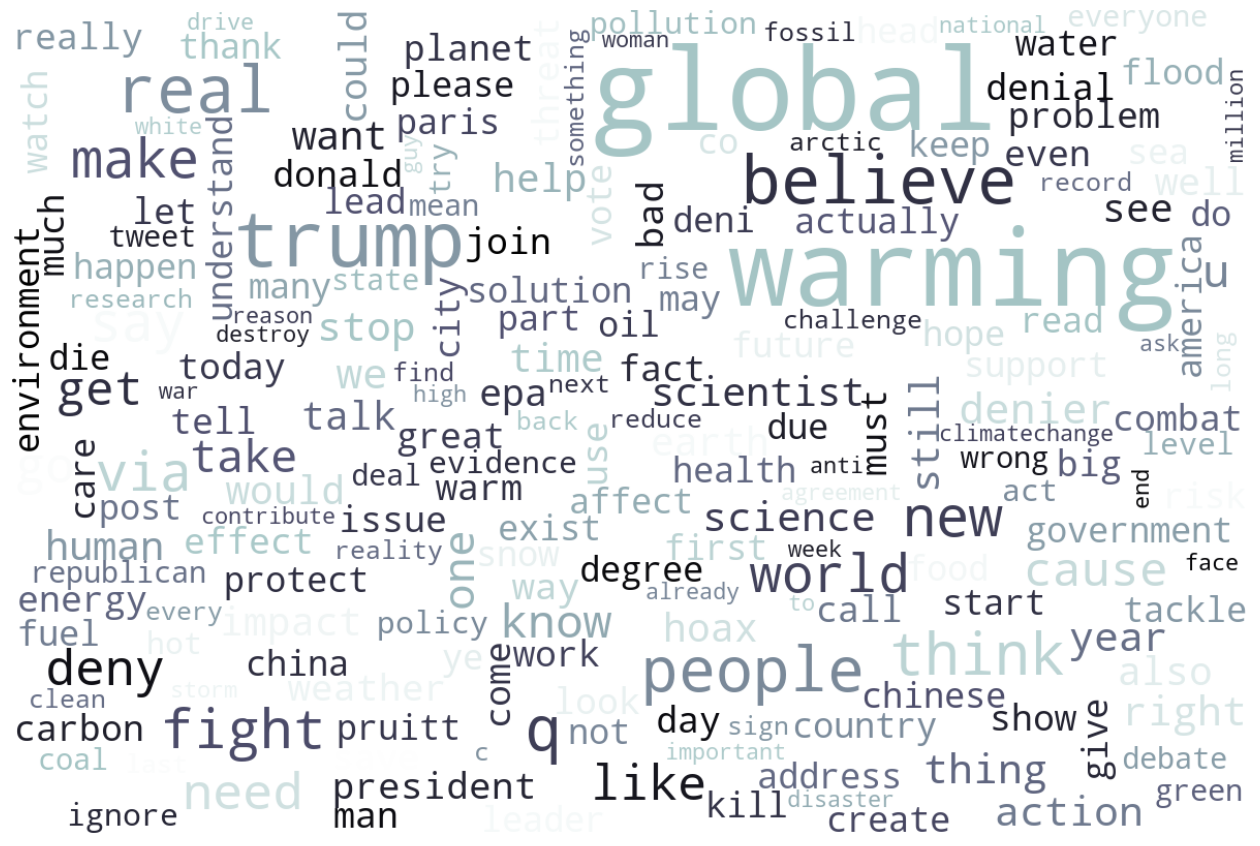

In [25]:
dat_pos = dat[dat['sentiment']==1]
draw_cloud(dat_pos['text_clean'], stopwords=['climate', 'change'])

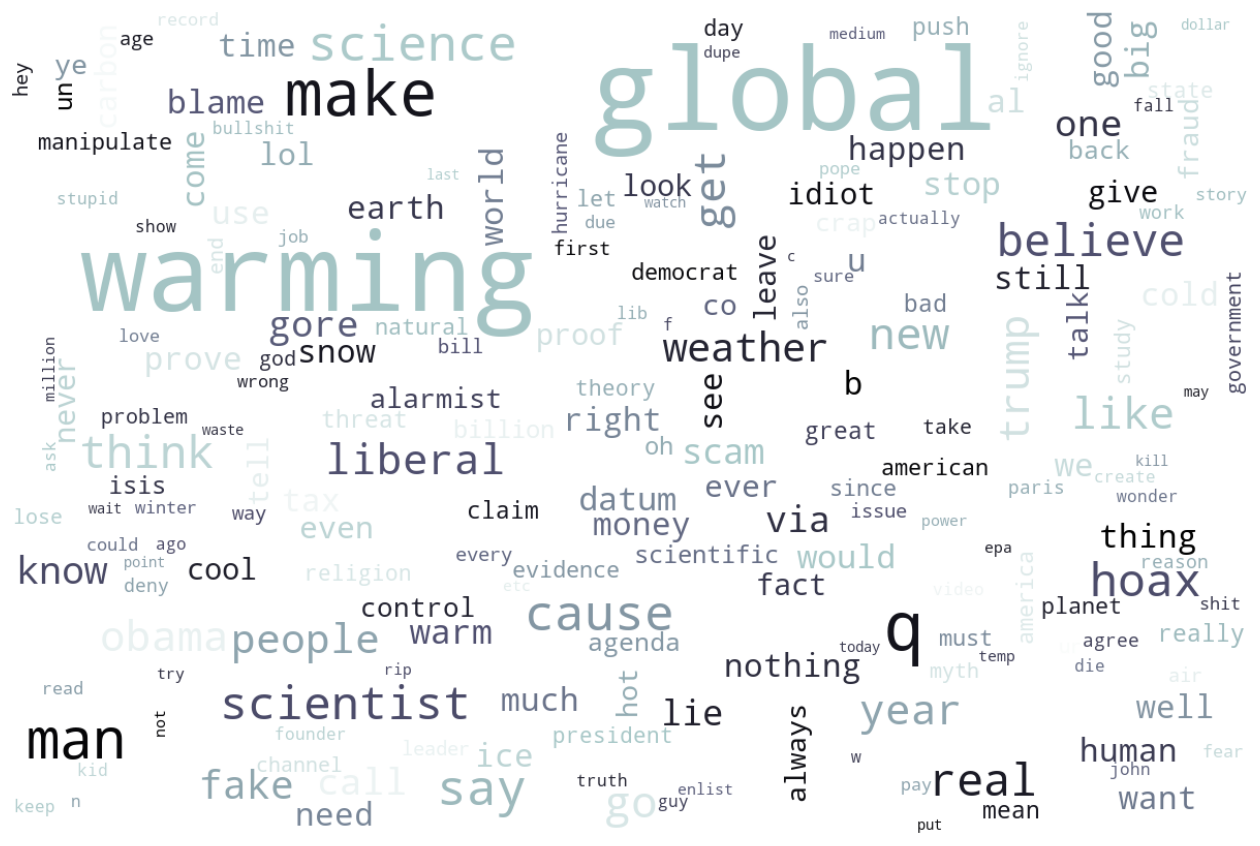

In [26]:
dat_neg = dat[dat['sentiment']==-1]
draw_cloud(dat_neg['text_clean'], stopwords=['climate', 'change'])

### Sentiment analysis

Next, we'll estimate the sentiment of the tweets. The data already has a column labeled `sentiment`, which is a category describing whether the tweet was for or against climate change (or neutral). Sentiment analysis is a little different from this, as it attempts to score some text based on whether the words are overall positive, neutral or negative, irrespective of the belief in or against climate change. There are several different lexicons for sentiment analysis, some of which provide more fine grained detail. We'll use one that's built into the NLTK package:

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

To illustrate how this works, we'll run it on two statements

In [28]:
print(analyzer.polarity_scores("I'm happy"))
print(analyzer.polarity_scores("I'm angry"))

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
{'neg': 0.767, 'neu': 0.233, 'pos': 0.0, 'compound': -0.5106}


This provides 4 scores: the proportion of negative, neutral and positive words, and a compound score based on all three. We can run this in a loop to get these scores for all tweets. We'll also store a binary indicator (positive vs. negative) for later use.

In [29]:
sent_pos = []
sent_neg = []
sent = []
for text in dat['text_clean']:
    scores = analyzer.polarity_scores(text)
    sent_pos.append(scores['pos'])
    sent_neg.append(scores['neg'])
    sentiment = 1 if scores['compound'] > 0 else 0
    sent.append(sentiment)

dat["sent_pos"] = sent_pos 
dat["sent_neg"] = sent_neg
dat["sent2"] = sent

We can use this to make new word clouds. For example, just the most positive tweets:

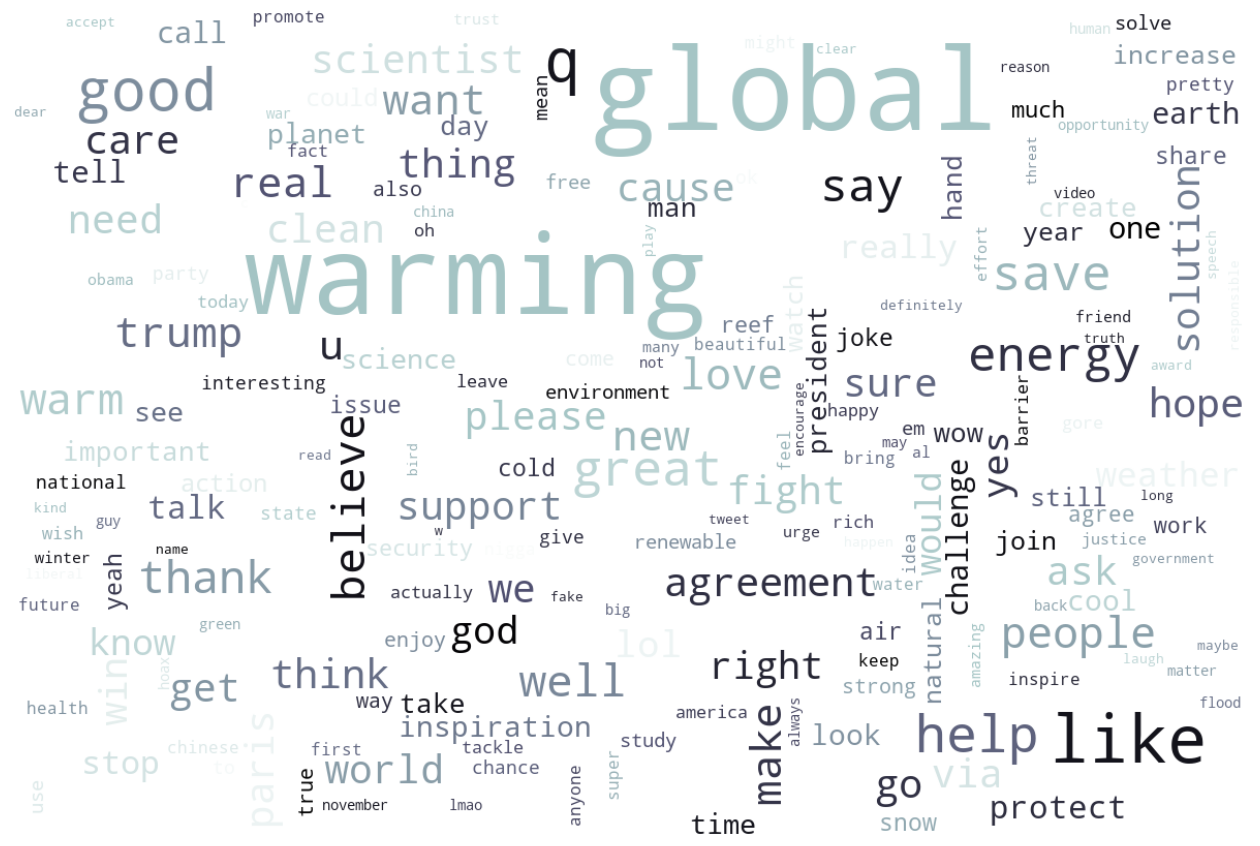

In [30]:
dat_neg = dat[dat['sent_pos']>0.4]
draw_cloud(dat_neg['text_clean'], stopwords=['climate', 'change'])

## Embedding text data

To go further in the analysis of text data, we need to use a text embedding. This converts the text to a numeric representation in a high dimensional space. The simplest form of this is one-hot encoding, which creates a binary matrix with one column per word, and one row per tweet. If the word occurs in that tweet, then it's labeled with a `1`, and a `0` if not. One hot encoding works well with a small number of words, but scales poorly with richer text. 

Embeddings are more complex representations of text, usually created by analyzing which words are likely to occur in similar contexts. It has a lot of similarities to principal component analysis for numeric data, in which complex data can be represented by a small number of *components* that capture correlations between the variables. For text, these means that the embedding for 'dog' and 'cat' will be similar, but 'dog' and 'car' will be dissimilar. This can then be used to explore the similarity between pieces of text, or (as we'll see below) to use text in machine learning models. These embeddings are a key part of large language models (e.g. ChatGPT), where they are used to relate prompts or questions to the appropriate text that makes up a response. 

While it's possible to create your own embedding (which is useful for specific projects), this can be quite time consuming, and can require a substantial amount of text. In the example we'll use below, we'll use an embedding that was created using a model called Word2Vec and trained using Google news articles. You can download the file that contains the embedding from the Google drive folder (`./wgts/`):

https://drive.google.com/drive/folders/1GMEY1fYEj1YMI__u3hU4y6agnrz3ekna?usp=drive_link

A good selection of alternative, pre-trained embeddings can be found at Hugging Face:

https://huggingface.co/models?other=text-embedding

We'll need some functions from the `gensim` package to find the embeddings for different pieces of text, and we'll need to load the embeddings file:

In [31]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
word_vectors = KeyedVectors.load_word2vec_format('./wgts/GoogleNews-vectors-negative300.bin', binary=True)

As an example, here is the embedding for the word 'cat':

In [32]:
print("Shape:", word_vectors["cat"].shape)
display(word_vectors["cat"])

Shape: (300,)


array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
        0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656,
        0.08056641, -0.5859375 , -0.00445557, -0.296875  , -0.01312256,
       -0.08349609,  0.05053711,  0.15136719, -0.44921875, -0.0135498 ,
        0.21484375, -0.14746094,  0.22460938, -0.125     , -0.09716797,
        0.24902344, -0.2890625 ,  0.36523438,  0.41210938, -0.0859375 ,
       -0.07861328, -0.19726562, -0.09082031, -0.14160156, -0.10253906,
        0.13085938, -0.00346375,  0.07226562,  0.04418945,  0.34570312,
        0.07470703, -0.11230469,  0.06738281,  0.11230469,  0.01977539,
       -0.12353516,  0.20996094, -0.07226562, -0.02783203,  0.05541992,
       -0.33398438,  0.08544922,  0.34375   ,  0.13964844,  0.04931641,
       -0.13476562,  0.16308594, -0.37304688,  0.39648438,  0.10693359,
        0.22167969,  0.21289062, -0.08984375,  0.20703125,  0.08935547,
       -0.08251953,  0.05957031,  0.10205078, -0.19238281, -0.09

It's pretty meaningless to us mortals, but this is a representation of the word 'cat' that a computer can work with. To follow the example given above, we can extract these for 'cat', 'dog' and 'car', and explore the correlations with these

In [33]:
cat_wv = word_vectors["cat"]
car_wv = word_vectors["car"]
dog_wv = word_vectors["dog"]

In [34]:
np.corrcoef([car_wv, cat_wv, dog_wv])

array([[1.        , 0.21381096, 0.30753512],
       [0.21381096, 1.        , 0.76076109],
       [0.30753512, 0.76076109, 1.        ]])

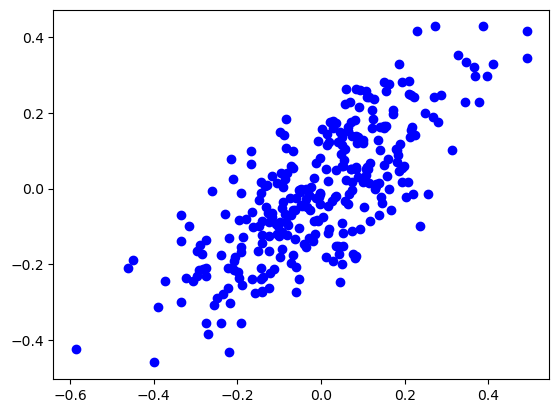

In [35]:
plt.plot(cat_wv, dog_wv, 'bo')

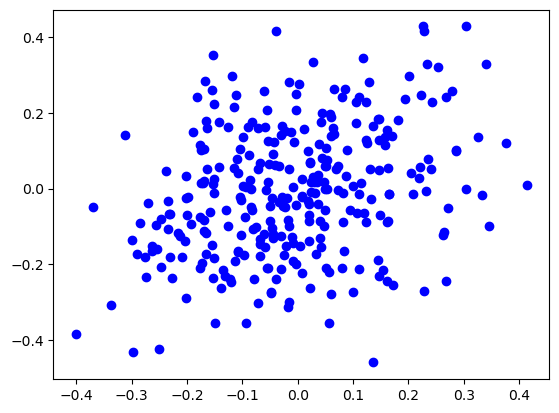

In [36]:
plt.plot(car_wv, dog_wv, 'bo')

The Word2Vec model embeds each word individually, so to get embeddings for each tweet, we'll need to loop by tweet, embed each word, then take the average. The following function does this. Note that this uses the tokenization function introduced above to split text into words. 

In [37]:
def word2vec_vectorize(text: str):
    """ Convert text document to the embedding vector """    
    vectors = []
    tokens = word_tokenize(text)
    for token in tokens:
        if token in word_vectors:
            vectors.append(word_vectors[token])
            
    return np.asarray(vectors).mean(axis=0) if len(vectors) > 0 else np.zeros(word_vectors.vector_size)

Now, we'll extract the tweets, and pass them through this function. We convert the resulting set of embeddings to a NumPy array for further processing.

In [38]:
docs = dat["text_clean"].values

vectorized_docs = list(map(word2vec_vectorize, docs))
vectorized_docs = np.array(vectorized_docs)
print("Shape:", vectorized_docs.shape)

Shape: (17312, 300)


The result (`vectorized_docs`) is a numeric array with 300 columns and the same number of rows as the cleaned tweets. We can now use any of the usual tools for exploring and modeling numeric data. 

### Cluster analysis

We'll first use scikit-learn's K-Means cluster function to group the tweets into 4 sets.

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 4
km = KMeans(n_clusters=k).fit(vectorized_docs)

We can also visualize the embeddings using other dimension reduction techniques. Here we use UMAP, a non-linear, efficient way of collapsing high-dimensional data to low (usually 2) dimensions

In [40]:
from umap import UMAP
docs_umap = UMAP(n_components=2, init='random', random_state=0)
docs_umap.fit_transform(vectorized_docs)

/opt/homebrew/Caskroom/miniforge/base/envs/tweets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/tweets/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


array([[ 5.7114234,  2.6261144],
       [ 6.598618 ,  3.6882699],
       [10.761188 ,  4.5631695],
       ...,
       [ 6.832501 ,  5.4620686],
       [ 3.9939172,  5.7363777],
       [ 1.8238599,  5.6441736]], dtype=float32)

This can be plotted - each point here represents an individual tweet, and the colors are the clusters we created in the previous step. Note there are quite a lot of outliers that could be potentially removed, and that one cluster is very distinct from the others. This may suggest a group of tweets that deal with different aspect of climate change. (You could plot the word cloud for these tweets to see if that shows some differences).

<Axes: >

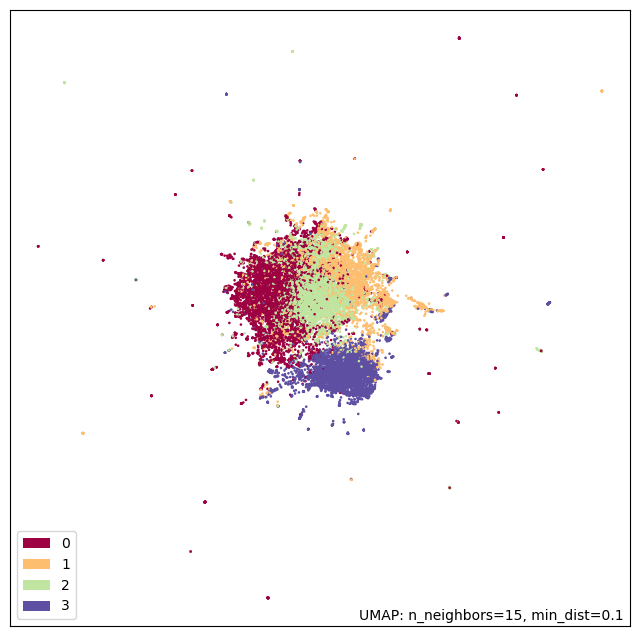

In [41]:
import umap.plot
#umap.plot.points(docs_umap, labels=dat['sent2'])
umap.plot.points(docs_umap, labels=km.labels_)

### Using embeddings in machine learning

As a last step, we'll briefly look at using these embeddings in a machine learning model. We'll build a model to try and predict the sentiment of a tweet (positive or negative) from it's content. We'll use a random forest model with the embeddings as features, and the binary sentiment value we created earlier as a label. 

In [42]:
from sklearn.ensemble import RandomForestClassifier
tweet_rf = RandomForestClassifier()

In [43]:
X = vectorized_docs
y = dat['sent2']

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8)

In [45]:
tweet_rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
y_pred = tweet_rf.predict(X_test)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7406872653768409

In [48]:
from sklearn.metrics import roc_auc_score
y_pred_prob = tweet_rf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_prob[:, 1])


0.8161697596592637

We get an accuracy score of about 75% (this may vary on your computer), suggesting that given a tweet, we'd be able to predict it's sentiment fairly well. This could be improved by tuning the model, using the sentiment score rather than the 0/1 indicator and, of course, including more data.

Wrapping up, this is a pretty quick overview of what can be done with NLP data. But it has hopefully shown the need for careful processing of the original text data, and how, once this is done, the text can be converted to a machine-readable form for a wide range of further analysis. 